# Synthetic Mode Generation

This notebook shows how modes can be elaborated from health states in an fmdtools model.

In [1]:
from fmdtools.sim.sample import FaultDomain, FaultSample
import fmdtools.sim.propagate as prop
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import multiprocessing as mp
import pandas as pd
import time

The Rover model is in defined rover_model.py, along with a few analysis methods.

In [2]:
from examples.rover.rover_model import Rover

Below we compare the space of hazards revealed by querying the model with:
   - identifed modes (modes that we identify up-front)
   - elaborated modes (modes generated by lists of forseeable parameter values)
   - randomly-generated modes (modes generated by randomly sampling ranges of parameter values)

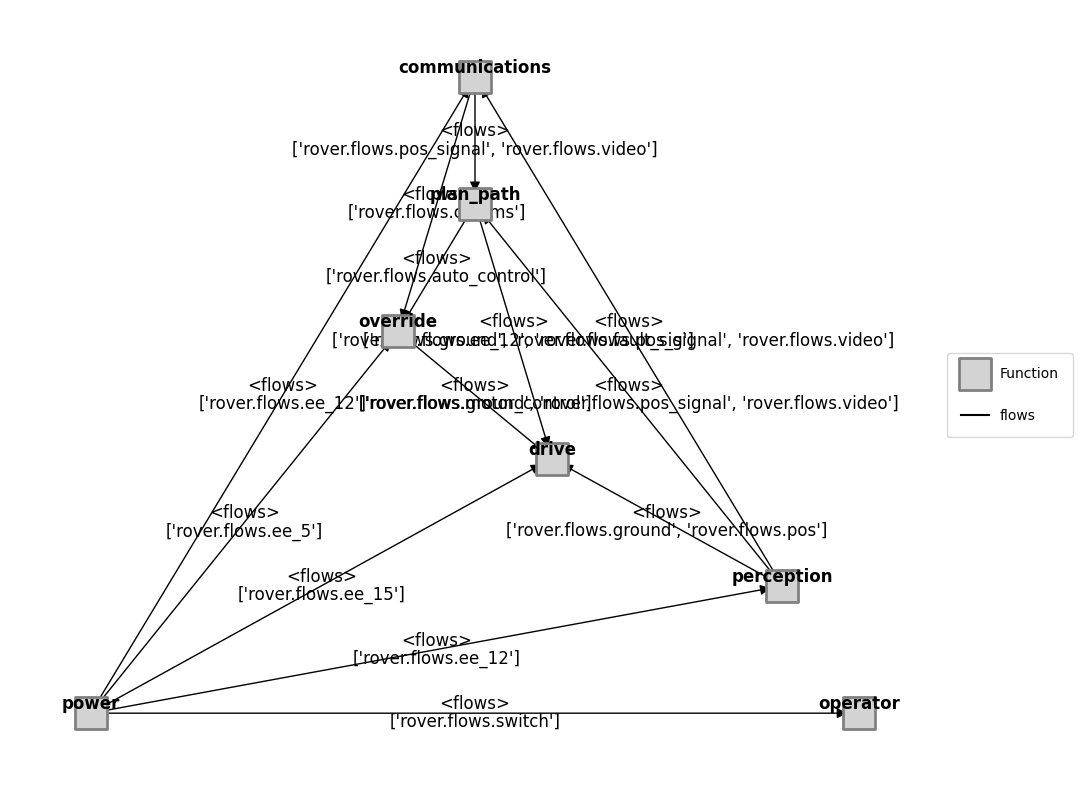

In [3]:
from fmdtools.define.architecture.function import FunctionArchitectureFxnGraph
mdl_illust = Rover()
mg = FunctionArchitectureFxnGraph(mdl_illust)
fig, ax = mg.draw()
colors = ["goldenrod", "magenta", "blue"]



In [4]:
fig.savefig("rover_structure.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [5]:
fig.savefig("rover_structure.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
from examples.rover.rover_mode_space import set_ranges, dist_ranges, p_test

In [7]:
mdl = Rover(p=p_test)
fd_range = FaultDomain(mdl)
fd_range.add_fault_space('drive', 'custom', dist_ranges)

In [8]:
from fmdtools.analyze.common import setup_plot
from mpl_toolkits.mplot3d import proj3d

def plot_labs(labs, x, y, z, fig):
    for i, label in enumerate(labs):
            xlab, ylab, _ = proj3d.proj_transform(x[i], y[i], z[i],  ax.get_proj())
            if label=='stuck_left':
                xyt=(-20,-30)
            elif label=='stuck':
                xyt=(20,-30)
            else:
                xyt=(20,30)
            plt.annotate(label, xy=(xlab, ylab), xytext=xyt, 
                textcoords='offset points', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1.0),
                arrowprops=dict(arrowstyle='-|>', color=colors[2]))

def plot_mode_space(faultdomain, size=30, alpha=0.5, label='', color='blue', marker='o', fig=None, ax=None, figsize=(4,4), show_labs=False):
    x = []
    y = []
    z = []
    labs = []
    for faulttup, fault in faultdomain.faults.items():
        dist_dict = dict(fault.disturbances)
        x.append(dist_dict.get('s.friction', 0.0))
        y.append(dist_dict.get('s.transfer', 1.0))
        z.append(dist_dict.get('s.drift', 0.0))
        labs.append(faulttup[1])

    fig, ax = setup_plot(fig=fig, ax=ax, figsize=figsize, z=True)
    ax.scatter(x, y, z, s=size, alpha=alpha, color=color, label=label, marker=marker)
    if show_labs:
        plot_labs(labs, x, y, z, fig)  
    return fig, ax

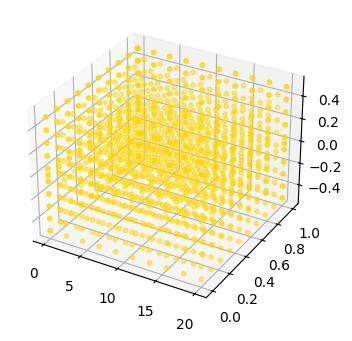

In [9]:
fig, ax = plot_mode_space(fd_range, label='range', color='gold', size=10, alpha=0.5)

In [10]:
fd_set = FaultDomain(mdl)
fd_set.add_fault_space('drive', 'custom', set_ranges)

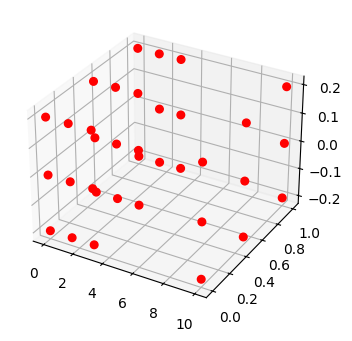

In [11]:
fig, ax = plot_mode_space(fd_set, color='red', alpha=1.0, label='set', size=30)

In [12]:
fd_id = FaultDomain(mdl)
fd_id.add_faults(('drive', 'stuck_right'), ('drive', 'stuck_left'), ('drive', 'stuck'), ('drive', 'elec_open'))

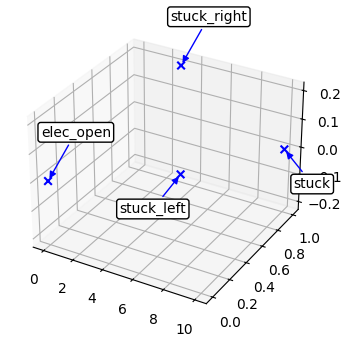

In [13]:
fig, ax = plot_mode_space(fd_id, color='blue', alpha=1.0, label='set', size=30, show_labs=True, marker='x')

In [14]:
def add_layer(fig, ax):
    proj=ax.get_tightbbox(fig.canvas.get_renderer())
    
    ax2 = fig.add_subplot(projection='3d')
    ax2.patch.set_alpha(0.0)
    xmin, ymin, zmin = proj3d.proj_transform(ax.get_xlim()[0], ax.get_ylim()[0], ax.get_zlim()[0],  ax.get_proj())
    xmax, ymax, zmax = proj3d.proj_transform(ax.get_xlim()[1], ax.get_ylim()[1], ax.get_zlim()[1],  ax.get_proj())
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_zlim(zmin, zmax)
    plt.axis('off')
    return ax2


def plot_mode_spaces(fd_range, fd_set, fd_id, title="Space of Fault Modes"):
    fig, ax = plot_mode_space(fd_range, label='range', color='goldenrod', size=5, alpha=0.25)
    fig, ax = plot_mode_space(fd_set, color='magenta', alpha=0.25, label='set', size=30, fig=fig, ax=ax)
    fig, ax = plot_mode_space(fd_id, color='blue', alpha=1.0, label='set', size=30, marker='x', fig=fig, ax=ax)
    ax.scatter([0], [1], [0], label="nominal", marker="*", s=50)
    ax2 = add_layer(fig, ax)
    fig, ax2 = plot_mode_space(fd_id, color='blue', alpha=1.0, label='set', size=30, show_labs=True, marker='x', fig=fig, ax=ax2)
    
    ax.set_title(title)

    ax.set_xlabel('friction')
    ax.set_ylabel('transfer')
    ax.set_zlabel('drift')
    ax.legend()
    return fig, ax

Below we compare the space of fault modes generated by our identified sets:

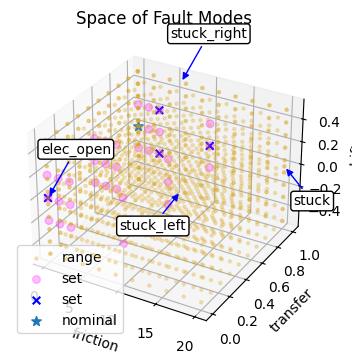

In [15]:
fig, ax = plot_mode_spaces(fd_range, fd_set, fd_id)

In [16]:
len(fd_range.faults)

1330

In [17]:
fig.savefig("hazard_space.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [18]:
fig.savefig("hazard_space.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Analysis
Below we look at how this results in different potential analyses...


Finding phases so the Approach can inject the fault halfway through the simulation.

In [19]:
import fmdtools.analyze.phases as ph
endresults, mdlhist = prop.nominal(mdl)
phasemap = ph.from_hist(mdlhist)
endresults

endclass: 
--rate:                              1.0
--cost:                                0
--prob:                              1.0
--expected_cost:                       0
--in_bound:                         True
--at_finish:                        True
--line_dist:                           1
--num_modes:                           0
--end_dist:                          0.0
--tot_deviation:    0.005246344989065292
--faults:                       array(0)
--classification:        nominal mission
--end_x:              29.813614084369863
--end_y:               17.26588133276667
--endpt:                        array(2)

Simulating the set and range approach. Note that the identified modes are present in the range and mode approaches, so we end up taking this data from these results afterwards.

We simulate it here to get some idea of the simulation time.

In [20]:
t_id_0 = time.time()
fault_sample_id = FaultSample(fd_id, phasemap['plan_path'])
fault_sample_id.add_fault_phases('drive')
results_id, mdlhists_id = prop.fault_sample(mdl, fault_sample_id, staged=True, pool=mp.Pool(5))
t_id = time.time()-t_id_0
t_id

SCENARIOS COMPLETE: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


2.0587589740753174

In [21]:
t_set_0 = time.time()
fs_set = FaultSample(fd_set, phasemap['plan_path'])
fs_set.add_fault_phases('drive')
results_set, mdlhists_set = prop.fault_sample(mdl, fs_set, staged=True, pool=mp.Pool(5))
t_set = time.time() - t_set_0
t_set

SCENARIOS COMPLETE: 100%|██████████| 35/35 [00:02<00:00, 14.95it/s]


2.602196216583252

In [22]:
t_range_0 = time.time()
fs_range = FaultSample(fd_range, phasemap['plan_path'])
fs_range.add_fault_phases('drive')
results_range, mdlhists_range = prop.fault_sample(mdl, fs_range, staged=True, pool=mp.Pool(5))
t_range = time.time() - t_range_0
t_range

SCENARIOS COMPLETE: 100%|██████████| 1330/1330 [00:14<00:00, 91.15it/s] 


15.134387016296387

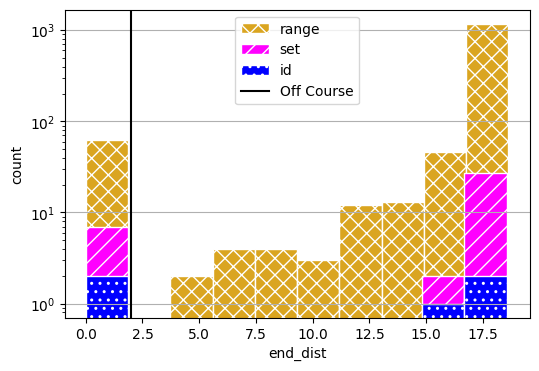

In [23]:
fig, axs = results_range.plot_metric_dist("end_dist", color=colors[0], hatch='xx', figsize=(6,4), edgecolor='white',
                                          comp_groups={'range': results_range.nest().keys()})
fig, axs = results_set.plot_metric_dist("end_dist", fig=fig, axs=axs, color=colors[1], hatch='//', edgecolor='white',
                                        comp_groups={'set': results_set.nest().keys()})
fig, axs = results_id.plot_metric_dist("end_dist", fig=fig, axs=axs, color=colors[2], hatch='..', edgecolor='white',
                                       comp_groups={'id': results_id.nest().keys()})
axs[0].axvline(2, label="Off Course", color="black")
axs[0].set_yscale("log")
axs[0].legend()

In [24]:
sim_times = [t_id, t_set, t_range]
sim_times

[2.0587589740753174, 2.602196216583252, 15.134387016296387]

In [25]:
fig.savefig("line_dist.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [26]:
fig.savefig("line_dist.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


as well as the discovery of fault trajectories...

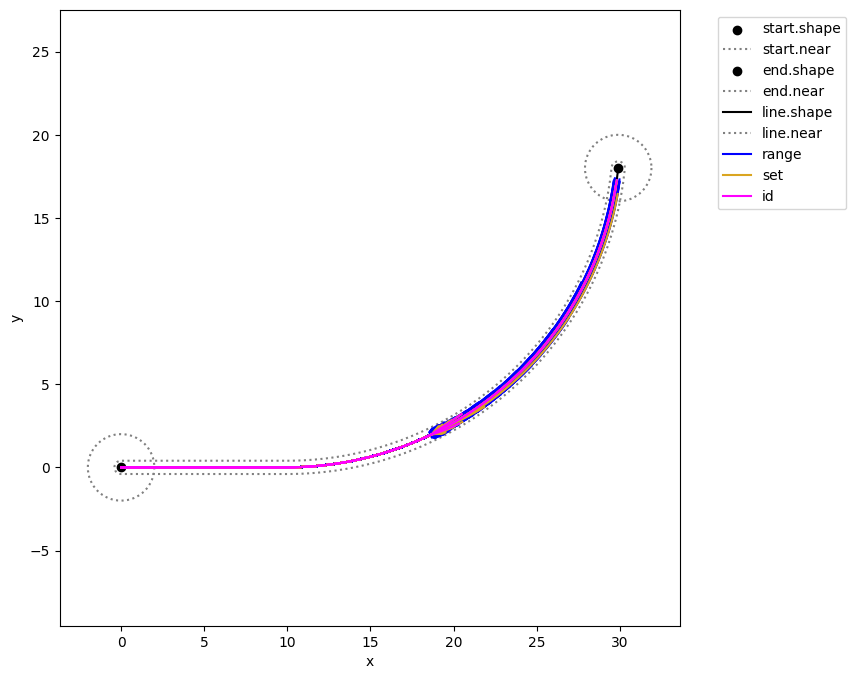

In [34]:
geoms = {'start': {'shapes': {'shape': {'color': 'black'}, 'near': {'color': 'grey', 'linestyle': 'dotted'}}},
        'end': {'shapes': {'shape': {'color': 'black'}, 'near': {'color': 'grey', 'linestyle': 'dotted'}}},
        'line': {'shapes': {'shape': {'color': 'black'}, 'near': {'color': 'grey', 'linestyle': 'dotted'}}}}
    
fig, ax = mdl.flows['ground'].ga.show(geoms, figsize = (8,8)) 

# comment out for tests/speed sake
fig, ax = mdlhists_range.plot_trajectories("flows.pos.s.x", "flows.pos.s.y", 
                                        comp_groups = {'range': list(mdlhists_range.nest().keys())}, 
                                        fig=fig, ax=ax, color = colors[2])
fig, ax = mdlhists_set.plot_trajectories("flows.pos.s.x", "flows.pos.s.y", 
                                         comp_groups = {'set': list(mdlhists_set.nest().keys())}, 
                                         color = colors[0], fig=fig, ax=ax)
fig, ax = mdlhists_id.plot_trajectories("flows.pos.s.x", "flows.pos.s.y", 
                                        comp_groups = {'id': list(mdlhists_id.nest().keys())}, 
                                        fig=fig, ax=ax, color = colors[1])

In [35]:
fig.savefig("fault_map.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [36]:
fig.savefig("fault_map.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Cluster Analysis

Below, we use clustering to identify similar sets of synthetic modes.

In [30]:
# import pip
# pip install scikit-learn

In [37]:
from sklearn.cluster import DBSCAN as cluster #DBSCAN
import numpy as np

In [40]:
def get_X(mdlhists, hmode = True):
    x = np.array([[value[-1]] for scen, value in mdlhists.get_values('flows.pos.s.x').items()])
    y = np.array([[value[-1]] for scen, value in mdlhists.get_values('flows.pos.s.y').items()])
    return np.concatenate((x, y), axis=1)
    

To find similar trajectories, we will cluster on the x-y coordinates of the end position of the Rover accross these scenarios:

In [62]:
X_range = get_X (mdlhists_range)
ec_range = [endclass for scen, endclass in results_range.get_values('end_dist').items() if scen[0:6]!='nominal']

In [63]:
X_set = get_X (mdlhists_set)
ec_set = [endclass for scen, endclass in results_set.get_values('end_dist').items() if scen[0:6]!='nominal']

In [76]:
X_id = get_X (mdlhists_id, hmode = False)
ec_id = [endclass for scen, endclass in results_id.get_values('end_dist').items() if scen[0:6]!='nominal']


To identify where all the clusters are accross all three approaches, we first have to combine the three sets of data into one (otherwise it might cluster differently).

In [77]:
X = np.concatenate((X_range, X_set, X_id))

This runs the clustering algorithm:

In [78]:
cl = cluster().fit(X)
labels = cl.labels_

The number of clusters is:

In [79]:
unique_labels = set(labels)
len(unique_labels)- (1 if -1 in labels else 0)

4

Here we plot the clusters on the course map to see what the algorithm identified.

C:\Users\dhulse\AppData\Local\Temp\1\ipykernel_21212\784500743.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  clust_colors = plt.cm.get_cmap('viridis', len(unique_labels)+1)


<Figure size 640x480 with 0 Axes>

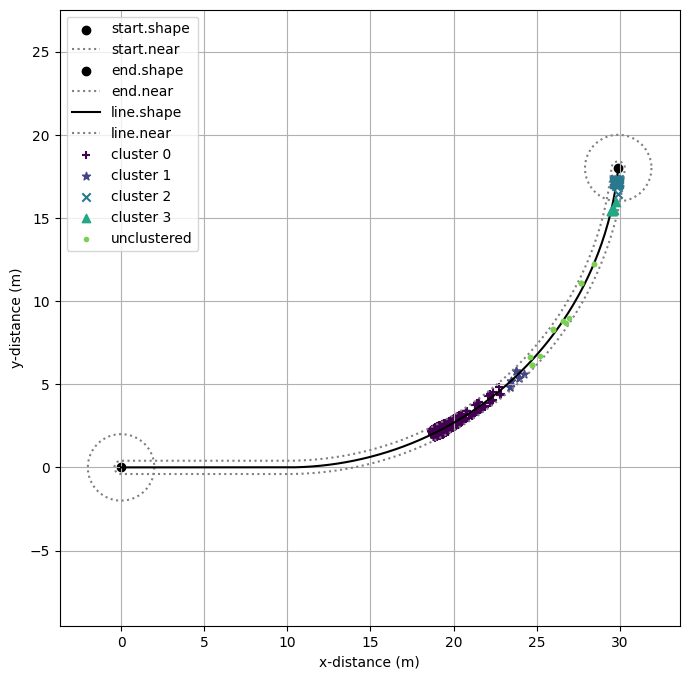

In [80]:
fig=plt.figure()
mdl.flows['ground'].ga.show(geoms, figsize = (8,8))
#clust_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#clust_colors.reverse()
clust_colors = plt.cm.get_cmap('viridis', len(unique_labels)+1)
markers = ["+","*","x","^","."]

for i, k in enumerate(unique_labels):
    x_label = [x[0] for i,x in enumerate(X) if labels[i]==k]
    y_label = [x[1] for i,x in enumerate(X) if labels[i]==k]
    if k == -1: clust_lab = 'unclustered'
    else:       clust_lab = 'cluster '+str(k)
    plt.scatter(x_label, y_label, zorder=i, label=clust_lab, color=clust_colors.colors[i], marker=markers[i]) 

#plt.scatter(X_set[:,0],X_set[:,1], label='set', color='black', marker='+') 

#plt.scatter(X_id[:,0],X_id[:,1], label='identified', color='gray', marker='X')  

plt.grid()
plt.xlabel('x-distance (m)')
plt.ylabel('y-distance (m)')

plt.legend()
fig = plt.gcf()

In [81]:
fig.savefig("cluster_map.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [82]:
fig.savefig("cluster_map.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Next, we would like to see how these approaches span the different clusters. If an approach has more coverage, we might say that it better explored the space.

In [83]:
categorizations = {tuple(x):labels[i] for i,x in enumerate(X)}

In [84]:
cat_values = {lab:{tuple(x) for x in X if lab==categorizations[tuple(x)]} for lab in set(labels)}

These are the categories found by each approach:

In [85]:
cat_range = [categorizations[tuple(x)] for x in X_range]
set(cat_range)

{-1, 0, 1, 2, 3}

In [86]:
cat_id = [categorizations[tuple(x)] for x in X_id]
set(cat_id)

{0, 2}

In [87]:
cat_set = [categorizations[tuple(x)] for x in X_set]
set(cat_set)

{0, 2}

In [88]:
ec_range

[18.212855187306467,
 17.880771586062338,
 12.97480547939998,
 17.304919376258646,
 18.15992894169864,
 9.465125171467097,
 17.072494800943055,
 17.63550537421338,
 17.92960283373589,
 17.926161520661,
 0.0,
 18.160411977987206,
 17.811098285415046,
 11.962856376045202,
 17.20021445899493,
 18.107972033888945,
 6.247923520595959,
 16.969489245356648,
 17.565909538279886,
 17.87580779695436,
 17.870028982816798,
 0.0,
 18.418450040639797,
 18.122472072307584,
 15.07168003139923,
 17.680999749424487,
 18.346533397417247,
 14.42565200789203,
 17.670554639726387,
 17.879888083653377,
 18.124189825231365,
 18.15065986239579,
 0.0,
 18.329590688049468,
 18.035205134978295,
 14.37113351947878,
 17.5430508824882,
 18.271455741177522,
 12.666149833487385,
 17.306929761613873,
 17.79099884406752,
 18.04763120305605,
 18.052212035287646,
 0.0,
 18.267454082042264,
 17.95509328259392,
 13.67247110611889,
 17.41852729995098,
 18.21430531405481,
 11.536024855214608,
 17.184299991893926,
 17.71011233

This function categorizes the results of each approach into the given clusters

In [89]:
def get_cats(categorizations, X, ec, unique_categorizations):
    cats={}
    for cat in unique_categorizations:
        cats[cat] = [ec[i] for i, x in enumerate(X) if categorizations[tuple(x)]==cat]+[0]
    return cats

In [90]:
cats = get_cats(categorizations, X_range, ec_range, unique_labels)

In [91]:
def worst_cat(categorizations, X, ec, unique_categorizations):
    worst_cats={}
    for cat in unique_categorizations:
        cats = [ec[i] for i,x in enumerate(X) if categorizations[tuple(x)]==cat]+[0]
        worst_cats[cat] = np.max(cats)
    return worst_cats

In [92]:
worst_cat_id = worst_cat(categorizations,X_id, ec_id, unique_labels)
worst_cat_range = worst_cat(categorizations,X_range, ec_range, unique_labels)
worst_cat_set = worst_cat(categorizations,X_set, ec_set, unique_labels)

This table shows the worst-case identified in each category

In [93]:
cat_tab = pd.DataFrame([[*worst_cat_id.values()], [*worst_cat_set.values()], [*worst_cat_range.values()]], index = ["Identified", "Set", "Range"], columns = worst_cat_id.keys())
cat_tab

,0,1,2,3,-1
Identified,18.536162,0.000000,0.000000,0.000000,0.000000
Set,18.536162,0.000000,0.556991,0.000000,0.000000
Range,18.621225,13.672471,0.000000,1.619383,11.962856


To view the coverage of each approach, here we plot the frequency of scenarios accross the clusters.

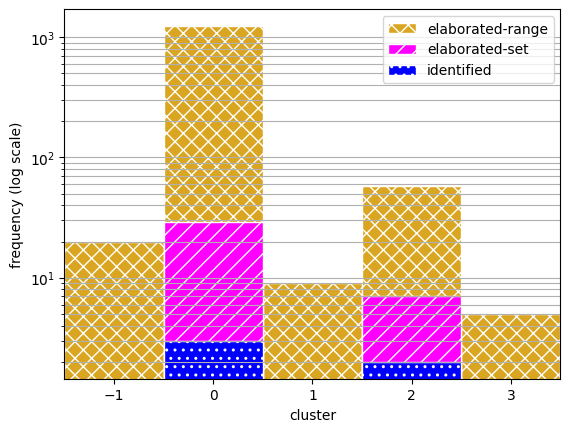

In [94]:
hatching = ['xx', '//', '..']
fig, ax = plt.subplots()
bins=np.array([-1,0,1,2,3,4])-0.5
ax.hist(cat_range, bins, label='elaborated-range', color=colors[0], hatch=hatching[0], edgecolor="white")
ax.hist(cat_set, bins, label='elaborated-set', color=colors[1], hatch=hatching[1], edgecolor="white")
ax.hist(cat_id, bins, label='identified', color=colors[2], hatch=hatching[2], edgecolor="white")
ax.set_xticks(bins + 0.5)
ax.set_xlim(-1.5,3.5)
ax.set_yscale("log")
ax.grid(axis='y', which='both')
ax.set_xlabel("cluster")
ax.set_ylabel("frequency (log scale)")
ax.legend()

In [95]:
fig.savefig("cluster_dist.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [96]:
fig.savefig("cluster_dist.eps", format="eps", bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Next, summarizing the overall stats from the approaches:

In [97]:
uncat_range = sum([i==-1 for i in cat_range])
uncat_set = sum([i==-1 for i in cat_set])
uncat_id = sum([i==-1 for i in cat_id])

In [98]:
uncat = [uncat_id, uncat_set, uncat_range]
lens = [len(X_id), len(X_set), len(X_range)]
num_cat = 100*np.array([len(set(cat_id))/len(unique_labels),len(set(cat_set))/len(unique_labels),len(set(cat_range))/len(unique_labels)])

In [99]:
res_tab = pd.DataFrame([lens, sim_times,num_cat, uncat])
res_tab.columns=['Identified', 'Elaborated-Set', 'Elaborated-Range']
res_tab.index=["Scenarios","Comp. Time (s)", "% Clusters", "Unclustered"]
res_tab

,Identified,Elaborated-Set,Elaborated-Range
Scenarios,5.000000,36.000000,1331.000000
Comp. Time (s),2.058759,2.602196,15.134387
% Clusters,40.000000,40.000000,100.000000
Unclustered,0.000000,0.000000,20.000000


In [100]:
print(res_tab.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Identified & Elaborated-Set & Elaborated-Range \\
\midrule
Scenarios & 5.00 & 36.00 & 1331.00 \\
Comp. Time (s) & 2.06 & 2.60 & 15.13 \\
% Clusters & 40.00 & 40.00 & 100.00 \\
Unclustered & 0.00 & 0.00 & 20.00 \\
\bottomrule
\end{tabular}



Finally, we use the following to calculate more detailed statistics about the cluster coverage.

In [101]:
def calc_2d_cov_loss(xmin, xmax, ymin, ymax, xs, ys):
    return calc_coverage_loss(xmin, xmax, xs)*calc_coverage_loss(ymin, ymax, ys)
def calc_coverage_loss(xmin, xmax, xs):
    if xs:
        return (xmax-np.max(xs)+np.min(xs)-xmin)/(xmax-xmin)
    else: 
        return  (xmax-xmin)/(xmax-xmin)
def get_xs_ys(values, X_type):
    return [v[0] for v in values if v in X_type], [v[1] for v in values if v in X_type]

In [102]:
cov_loss_id,cov_loss_set,cov_loss_range = [],[],[]
num_scens_id,num_scens_set,num_scens_range = [],[],[]
for cat, values in cat_values.items():
    xs = [v[0] for v in values]
    ys = [v[1] for v in values]
    xs_id, ys_id = get_xs_ys(values, X_id)
    xs_set, ys_set = get_xs_ys(values, X_set)
    xs_range, ys_range = get_xs_ys(values, X_range)
    xmin,xmax,ymin,ymax = np.min(xs), np.max(xs), np.min(ys), np.max(ys)
    
    cov_loss_id.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax ,xs_id,ys_id))
    cov_loss_set.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax ,xs_set,ys_set))
    cov_loss_range.append(calc_2d_cov_loss(xmin,xmax,ymin,ymax, xs_range,ys_range))
    
    num_scens_id.append(len(xs_id));num_scens_set.append(len(xs_set));num_scens_range.append(len(xs_range))

Coverage Compared to the range approach:

In [103]:
cov_tab = pd.DataFrame([cov_loss_id,cov_loss_set,cov_loss_range], columns=list(cat_values.keys()), index = ["Identified", "Set", "Range"])

cov_tab

,0,1,2,3,-1
Identified,0.348938,1.0,0.704326,1.0,1.0
Set,0.116869,1.0,0.073416,1.0,1.0
Range,0.000000,0.0,0.000000,0.0,0.0


Number of scenarios per approach for each cluster:

In [104]:
scens_tab = pd.DataFrame([num_scens_id,num_scens_set,num_scens_range], columns=list(cat_values.keys()), index = ["Identified", "Set", "Range"], dtype=int)

scens_tab

,0,1,2,3,-1
Identified,3,0,2,0,0
Set,18,0,7,0,0
Range,933,5,39,4,10


In [105]:
len(cat_values[0])

950

Combined Table:

In [106]:
comb = pd.concat({"# Scenarios":scens_tab, "Coverage Loss":cov_tab, "Worst-Case":cat_tab}, axis="columns",join='inner')
comb = comb.swaplevel(0, axis="columns")
#index = pd.MultiIndex.from_tuples(comb.columns)
#comb = comb.reindex(index, axis="columns")
comb = comb.sort_index(axis="columns")
comb = comb.T
#comb_2.index = comb.index
comb

Identified        Set       Range
-1 # Scenarios      0.000000   0.000000   10.000000
   Coverage Loss    1.000000   1.000000    0.000000
   Worst-Case       0.000000   0.000000   11.962856
 0 # Scenarios      3.000000  18.000000  933.000000
   Coverage Loss    0.348938   0.116869    0.000000
   Worst-Case      18.536162  18.536162   18.621225
 1 # Scenarios      0.000000   0.000000    5.000000
   Coverage Loss    1.000000   1.000000    0.000000
   Worst-Case       0.000000   0.000000   13.672471
 2 # Scenarios      2.000000   7.000000   39.000000
   Coverage Loss    0.704326   0.073416    0.000000
   Worst-Case       0.000000   0.556991    0.000000
 3 # Scenarios      0.000000   0.000000    4.000000
   Coverage Loss    1.000000   1.000000    0.000000
   Worst-Case       0.000000   0.000000    1.619383

In [107]:
print(comb.to_latex( ))

\begin{tabular}{llrrr}
\toprule
 &  & Identified & Set & Range \\
\midrule
\multirow[t]{3}{*}{-1} & # Scenarios & 0.000000 & 0.000000 & 10.000000 \\
 & Coverage Loss & 1.000000 & 1.000000 & 0.000000 \\
 & Worst-Case & 0.000000 & 0.000000 & 11.962856 \\
\cline{1-5}
\multirow[t]{3}{*}{0} & # Scenarios & 3.000000 & 18.000000 & 933.000000 \\
 & Coverage Loss & 0.348938 & 0.116869 & 0.000000 \\
 & Worst-Case & 18.536162 & 18.536162 & 18.621225 \\
\cline{1-5}
\multirow[t]{3}{*}{1} & # Scenarios & 0.000000 & 0.000000 & 5.000000 \\
 & Coverage Loss & 1.000000 & 1.000000 & 0.000000 \\
 & Worst-Case & 0.000000 & 0.000000 & 13.672471 \\
\cline{1-5}
\multirow[t]{3}{*}{2} & # Scenarios & 2.000000 & 7.000000 & 39.000000 \\
 & Coverage Loss & 0.704326 & 0.073416 & 0.000000 \\
 & Worst-Case & 0.000000 & 0.556991 & 0.000000 \\
\cline{1-5}
\multirow[t]{3}{*}{3} & # Scenarios & 0.000000 & 0.000000 & 4.000000 \\
 & Coverage Loss & 1.000000 & 1.000000 & 0.000000 \\
 & Worst-Case & 0.000000 & 0.000000 & 1.6